
# **2 Training**

Scientific Computing Infrastructure


## 1. Preparations
### 1.1 Import required packages

In [63]:
import json
import os
import zipfile
import numpy as np
import geopandas as gpd
import sklearn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import importlib

In [64]:
print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

from torch import nn

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


### 1.2 Install segmentation model library

In [65]:
# !pip install segmentation-models-pytorch

In [66]:
import segmentation_models_pytorch as smp

### 1.3 Set device agnostic code

In [67]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU identified")

CUDA available: True
CUDA Version: 12.4
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 2080 Ti


In [68]:
# use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.4 Import data directories and configs-file

In [69]:
import os
print(os.path.abspath("configs"))

/home/sc.uni-leipzig.de/rf37uqip/MoSE/notebooks/configs


In [70]:
# path to repository folder
import sys
sys.path.append(os.path.abspath('/home/sc.uni-leipzig.de/rf37uqip/MoSE/'))

In [71]:
# import configs.py-file
from configs import configs_sc
importlib.reload(configs_sc) # reload changes

<module 'configs.configs_sc' from '/home/sc.uni-leipzig.de/rf37uqip/MoSE/configs/configs_sc.py'>

In [72]:
# input directories: patches and masks
patches_dir = configs_sc.DATA_DIR["patches"]
masks_dir = configs_sc.DATA_DIR["masks"]

# output directories: trained models
saved_model_dir = configs_sc.DATA_DIR["saved_models"]

# additional directories: class (labels and) codes
# labels_dir = configs_sc.DATA_DIR["labels"]
codes_dir = configs_sc.DATA_DIR["codes"]

### 1.5 Import and reload scripts

In [73]:
# import data_utils.py helper-functions script
from scripts import data_utils
importlib.reload(data_utils) # reload changes

# import model_utils.py helper-functions script
from scripts import model_utils
importlib.reload(model_utils) # reload changes

# import train_utils.py helper-functions script
from scripts import train_utils
importlib.reload(train_utils) # reload changes

# import evaluation_utils.py helper-functions script
from scripts import evaluation_utils
importlib.reload(evaluation_utils) # reload changes

# import visualization_utils.py helper function script
from scripts import visualization_utils
importlib.reload(visualization_utils) # reload changes

<module 'scripts.visualization_utils' from '/home/sc.uni-leipzig.de/rf37uqip/MoSE/scripts/visualization_utils.py'>

### 1.6 Check the data

a. Class codes dict

In [74]:
codes_path = os.path.join(codes_dir, "label_codes_ohe.json") # path

# open and load the JSON file
with open(codes_path, "r") as json_file:
    codes = json.load(json_file)

# reversed dictionary
reversed_codes = {v: k for k, v in codes.items()} # v = value, k = key
print(reversed_codes[4])
print(reversed_codes)

gravel bar
{1: 'woody debris', 2: 'rootstock', 3: 'sand/mud bar', 4: 'gravel bar', 0: 'background'}


b. Preprocessed patches

In [75]:
# list of all .npy-files (preprocessed patches)
################################################################################
patches_list = [f for f in os.listdir(patches_dir) if f.endswith('.npy')]
patches_list[0:3], len(patches_list)

(['A01_patch_142.npy', 'A01_patch_0.npy', 'A01_patch_144.npy'], 3836)

Shape of the patches: (3, 512, 512)
Datatype: float64
Type: <class 'numpy.ndarray'>
Mean: 0.17565934532858182
Minimum value: -2.1179039301310043
Maximum value: 2.6225708061002178


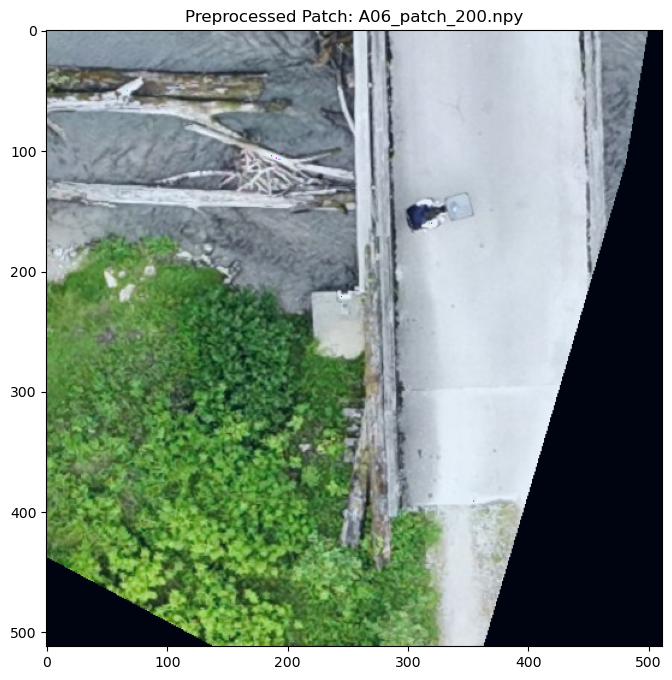

In [76]:
# Test one preprocessed patch
################################################################################

##################### choose single patch by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 200 # -------------------->> ADJUSTABLE
#####################

# load the path to the patch
test_patch_name = f"{SECTION}_patch_{TEST_PATCH_ID}.npy"
test_patch_path = patches_dir + f"/" + test_patch_name

# load npz-file
test_patch = np.load(test_patch_path)

  # Show characteristics of the patch
print("Shape of the patches:", test_patch.shape)
print("Datatype:", test_patch.dtype)
print("Type:", type(test_patch))
print("Mean:", np.mean(test_patch))
print("Minimum value:", np.min(test_patch))
print("Maximum value:", np.max(test_patch))

# import the norm_plot_patch function for normalization and plotting of the test patch
visualization_utils.norm_plot_patch(test_patch, test_patch_name)

3. Masks

In [77]:
# list of all masks
################################################################################

masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # list of all masks
print(masks_list[0:3])
len(masks_list)

['A01_patch_180_mask.npy', 'A01_patch_0_mask.npy', 'A01_patch_138_mask.npy']


3836

In [78]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 200 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen mask
test_mask_name = f"{SECTION}_patch_{TEST_MASK_ID}_mask.npy"
test_mask_path = masks_dir + f"/" + test_mask_name

# Load mask
test_mask = np.load(test_mask_path)

# Show properties of the mask
print("Shape of the mask:", test_mask.shape)
print("Datatype:", test_mask.dtype)
print("Type:", type(test_mask))
print("Minimum value:", np.min(test_mask))
print("Maximum value:", np.max(test_mask))
print("Unique values:", np.unique(test_mask), "\n") # binary mask



Shape of the mask: (5, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 1
Unique values: [0 1] 



Plot the mask

A06_patch_200_mask.npy


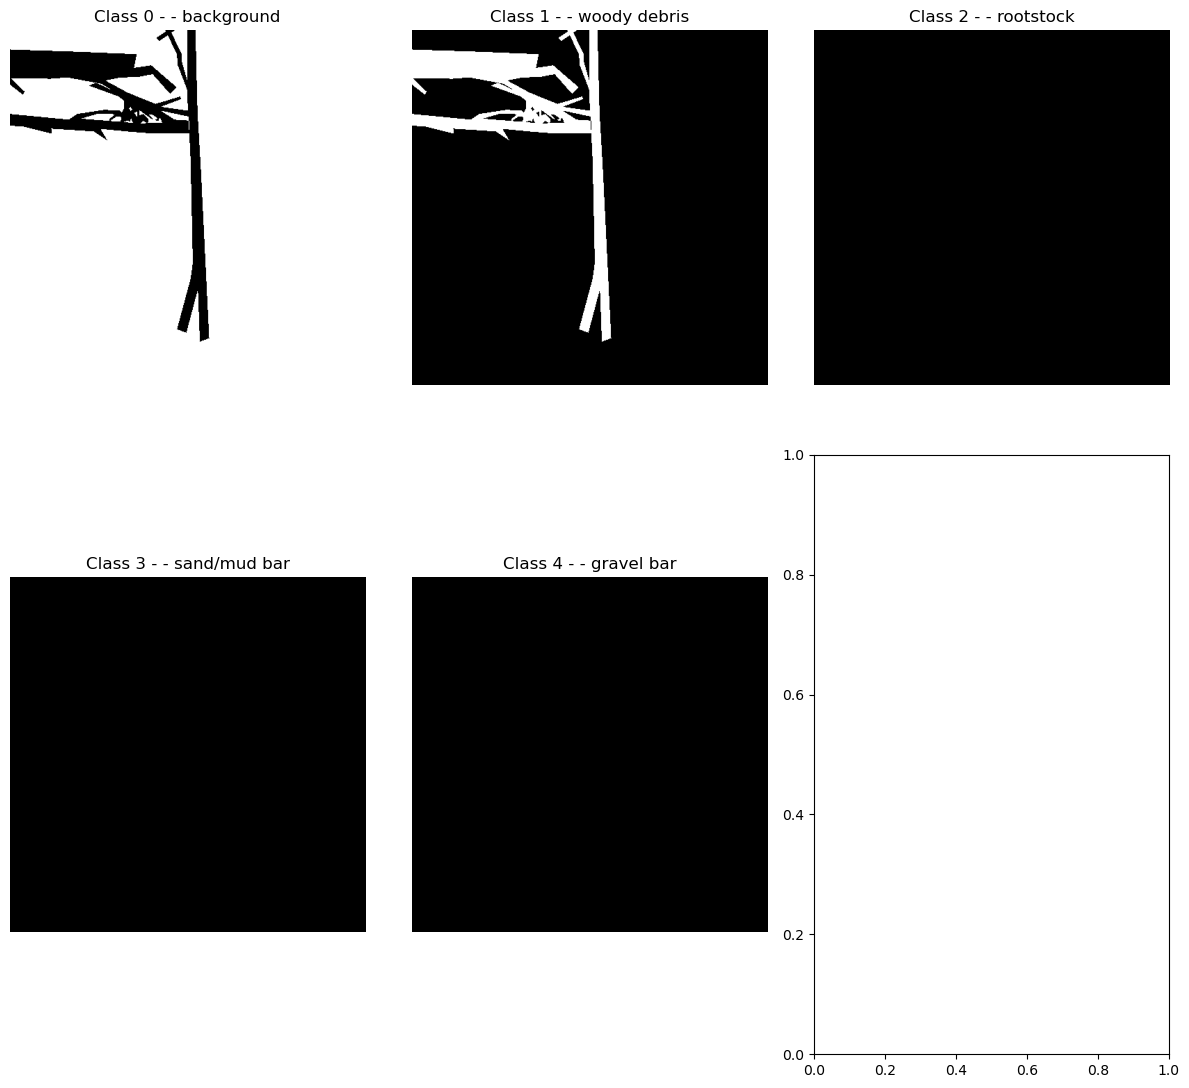

In [79]:
# ONE-HOT-ENCODED
print(test_mask_name)
fig, axes = plt.subplots(2, 3, figsize=(12, 12))  # 2x3 grid (for 5 classes)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask.shape[0]):  # iterate through the classes
  axes[i].imshow(test_mask[i], cmap="gray")
  axes[i].set_title(f"Class {i} - - {reversed_codes[i]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

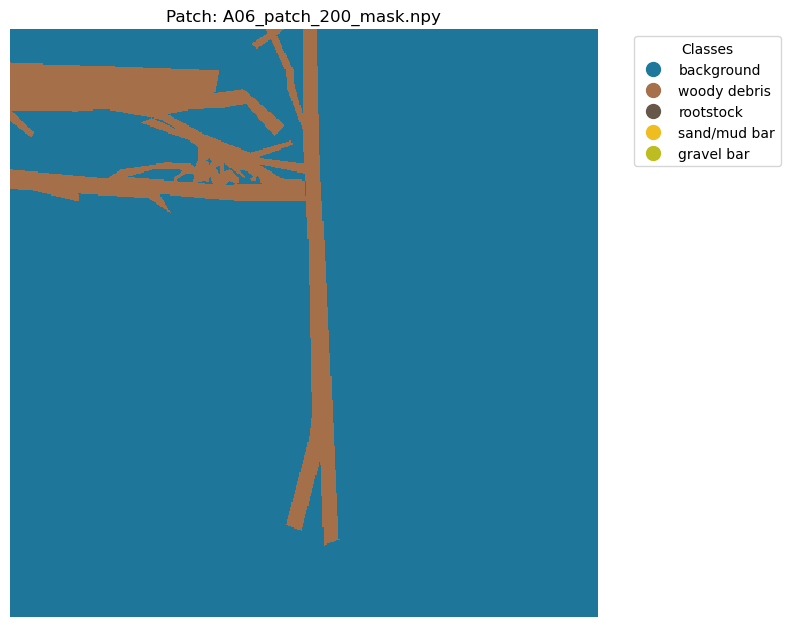

In [80]:
# alternative way of plotting the masks - not in one-hot-encoded, but in class-index-format
# CLASS-INDEX-FORMAT

# convert into class-index format
test_mask_idxformat = np.argmax(test_mask, axis=0)

visualization_utils.plot_mask_idxformat(test_mask_idxformat, test_mask_name, reversed_codes, configs_sc.HYPERPARAMETERS["custom_colors"])

## 2. Splitting data into train and test datasets

In [81]:
# extract section and patch_id from masks and patches (utils function)
print(data_utils.extract_section_and_id(masks_list[2]))
print(data_utils.extract_section_and_id(patches_list[175]))

('A01', '138')
('A01', '255')


In [82]:
# group patches by section
################################################################################

section_patches = {} # empty dictionary
for patch in patches_list: # iterate over all preprocessed patches
    section, patch_id = data_utils.extract_section_and_id(patch) # extract section and id
    section_patches.setdefault(section, []).append((patch)) # creates keys of sections with their patches inside

print(section_patches.keys())
# print(section_patches)

dict_keys(['A01', 'A02', 'A04', 'A06', 'A03', 'A05', 'A07', 'A08'])


In [83]:
# Separate patches in Training and Validation/Test datasets by sections
################################################################################

# empty lists for patches
train_data = []
test_data = []

for section, files in section_patches.items(): # iterates through the dictionary of sections
    if section in configs_sc.HYPERPARAMETERS["train_sections"]: # if the section is a training section
        train_data.extend(files) # if yes, the patches are added to the training data
    elif section in configs_sc.HYPERPARAMETERS["test_sections"]:
        test_data.extend(files)

print(f"Training Patches: {len(train_data)}")
print(f"Test Patches: {len(test_data)}")
print(f"Testdata-Ratio: {100*(len(test_data)/len(train_data))}")
print(f"Traindata-Ratio: {100 - 100*(len(test_data)/len(train_data))}")

Training Patches: 3077
Test Patches: 759
Testdata-Ratio: 24.666883327916803
Traindata-Ratio: 75.3331166720832


In [84]:
# Show random patch name in training data
print(train_data[8])

# test if this random patch has a corresponding mask
data_utils.has_mask(train_data[8], masks_dir)

A01_patch_146.npy


True

In [85]:
# Separate training and test patches 
################################################################################

train_data = [f for f in train_data if data_utils.has_mask(f, masks_dir)]
test_data = [f for f in test_data if data_utils.has_mask(f, masks_dir)]

print(f"Training data- Number of patches: {len(train_data)}")
print(f"Test data - Number of patches: {len(test_data)}")

Training data- Number of patches: 3077
Test data - Number of patches: 759


## 3. Data augmentation, Dataset and DataLoader

### 3.1 Data augmentation

In [86]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define training transformations with augmentation using Albumentations
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),  # horizontal flip with a probability of 0.5
    A.VerticalFlip(p=0.5), #  vertical flip 
    A.RandomRotate90(p=0.5), # randomly rotate the image by 90 degrees 
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5), # random adjustments to brightness, contrast, saturation, and hue
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=90, p=0.5), # shift, scale and rotation
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalize the image using ImageNet statistics
    ToTensorV2() # covert to Tensors
], additional_targets={'mask': 'mask'}) # ensures the same transformation is applied to the mask


# Define test transformations without augmentation (only normalization and conversion to tensor)
test_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalize the image using ImageNet statistics
    ToTensorV2() # covert to Tensors
], additional_targets={'mask': 'mask'}) # ensures the same transformation is applied to the mask

### 3.2 Dataset

In [ ]:
# # Apply Datasets and check properties
# ################################################################################

# # Train dataset
# train_dataset = data_utils.PatchDatasetCplx(train_data, patches_dir, masks_dir, transform = train_transforms)

# # check properties of the train dataset:
# print("Train dataset:\n")
# print("Type of dataset:", type(train_dataset))
# print("Number of patches:", len(train_dataset))
# print("Random patch:", train_dataset[0][0])
# print("Patch shape:", train_dataset[0][1].shape)
# print("Mask shape:", train_dataset[0][2].shape, "\n")

# # Test datasets
# test_dataset = data_utils.PatchDatasetSimpleCplx(test_data, patches_dir, masks_dir, transform = test_transforms) 

# # check properties of the test dataset:
# print("Test dataset:\n")
# print("Type of dataset:", type(test_dataset))
# print("Number of patches:", len(test_dataset))
# print("Random patch:", test_dataset[0][0])
# print("Patch shape:", test_dataset[0][1].shape)
# print("Mask shape:", test_dataset[0][2].shape, "\n")

In [87]:
# Apply Datasets and check properties
################################################################################

# Train dataset
train_dataset = data_utils.PatchDatasetSimple(train_data, patches_dir, masks_dir)

# check properties of the train dataset:
print("Train dataset:\n")
print("Type of dataset:", type(train_dataset))
print("Number of patches:", len(train_dataset))
print("Random patch:", train_dataset[0][0])
print("Patch shape:", train_dataset[0][1].shape)
print("Mask shape:", train_dataset[0][2].shape, "\n")

# Test datasets
test_dataset = data_utils.PatchDatasetSimple(test_data, patches_dir, masks_dir) 

# check properties of the test dataset:
print("Test dataset:\n")
print("Type of dataset:", type(test_dataset))
print("Number of patches:", len(test_dataset))
print("Random patch:", test_dataset[0][0])
print("Patch shape:", test_dataset[0][1].shape)
print("Mask shape:", test_dataset[0][2].shape, "\n")

Train dataset:

Type of dataset: <class 'scripts.data_utils.PatchDataset'>
Number of patches: 3077
Random patch: A01_patch_142.npy
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512]) 

Test dataset:

Type of dataset: <class 'scripts.data_utils.PatchDataset'>
Number of patches: 759
Random patch: A04_patch_30.npy
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512]) 



### 3.3 DataLoader

Right now our data is in the form of Pytorch Datasets (see above). The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or simply `DataLoader`.

The `DataLoader`
- helps load data into a model.
- for training and for inference.
- **turns a large `Dataset` into a Python iterable** of smaller chunks. These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

In [88]:
from torch.utils.data import DataLoader

BATCH_SIZE = configs_sc.HYPERPARAMETERS["batch_size"]

# Train DataLoader
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print("Dataloader:", train_loader)

# Test DataLoader
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Check dataloader
print(f"Training Batches: {len(train_loader)}", f"= up to {len(train_loader)*BATCH_SIZE} patches")
print(f"Test Batches: {len(test_loader)}", f"= up to {len(test_loader)*BATCH_SIZE} patches")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x152fe8455670>
Training Batches: 385 = up to 3080 patches
Test Batches: 95 = up to 760 patches


### 3.4 Data exploration and class weights

In [89]:
# # Explore one batch of data in train_loader
# for batch_idx, (names, images, masks) in enumerate(train_loader):
#     print(f"Batch {batch_idx + 1}:", "\n------------\n------------")
#     print(f"Names - first patch name of the batch: {names[0]}", "\n------------")
#     print(f"Image type: {type(images)}")
#     print(f"Images shape: {images.shape}")  # Should be [batch_size, channels, height, width]
#     print(f"Image excerpt of the first patch: {images[0,:,:4,:4]}")
#     print(f"Images dtype: {images.dtype}", "\n------------")
#     print(f"Masks shape: {masks.shape}")    # Should be [batch_size, channels, height, width]
#     print(f"Mask excerpt of the mask of the fourth patch: {masks[0,:,:2,:2]}")
#     print(f"Masks dtype: {masks.dtype}")
#     break # break after first batch (batch 1)

Pixel Distribution (%):
Class 0: 98.56%
Class 1: 1.44%


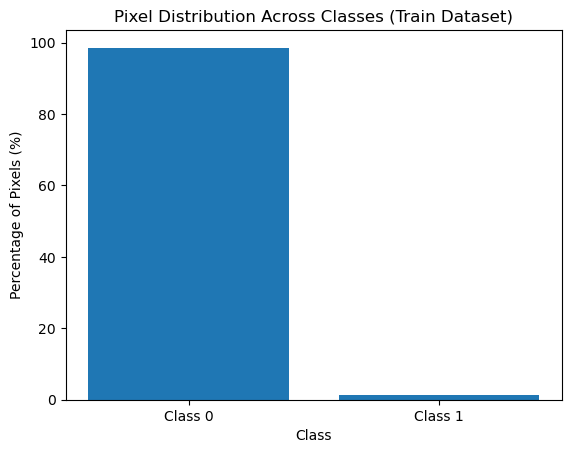

In [94]:
# TRAIN LOADER
# Show pixel distribution per class in train_loader
pixel_distribution_train = data_utils.pixel_distribution_dataloader(
    data_loader=train_loader,
    num_classes= configs_sc.HYPERPARAMETERS["num_classes"],
    device=device
)

# Visualize results
plt.bar(pixel_distribution_train.keys(), pixel_distribution_train.values())
plt.xlabel("Class")
plt.ylabel("Percentage of Pixels (%)")
plt.title("Pixel Distribution Across Classes (Train Dataset)")
plt.xticks()
plt.show()

In [91]:
# # TEST LOADER
# # Show pixel distribution per class in test_loader
# pixel_distribution_test = data_utils.pixel_distribution_dataloader(
#     data_loader=test_loader,
#     num_classes= configs_sc.HYPERPARAMETERS["num_classes"],
#     device=device
# )

# # Visualize results
# plt.bar(pixel_distribution_test.keys(), pixel_distribution_test.values())
# plt.xlabel("Class")
# plt.ylabel("Percentage of Pixels (%)")
# plt.title("Pixel Distribution Across Classes (Test Dataset)")
# plt.xticks()
# plt.show()

In [95]:
# pixel_dist_train = torch.tensor(list(pixel_distribution_train.values()), dtype=torch.float32, device=device)
pixel_dist_train = torch.tensor([98.5564,  1.4437], dtype=torch.float32, device=device)
print("Pixel distribution in train dataset:", pixel_dist_train)

Pixel distribution in train dataset: tensor([98.5564,  1.4437], device='cuda:0')


In [96]:
# calculate the weights to outweigh the class imbalances
class_weights = 1/ (pixel_dist_train/100)
print("Class weights:", class_weights)

normalized_weights = class_weights / class_weights.sum()
print("Normalized weights:", normalized_weights)

Class weights: tensor([ 1.0146, 69.2665], device='cuda:0')
Normalized weights: tensor([0.0144, 0.9856], device='cuda:0')


To take into account the class imbalances in this dataset, we adjust the weight parameters in the CrossEntropyLoss function accordingly. Based on the pixel distribution, the weights can be set as follows:

| Class | Average pixel distribution (%) | Normalized Weight |
| ----- | ----- | ----- |
| 0 | 98.5564 | 0.0144 |
| 1 | 1.4437   | 0.9856 |


(
| 2 | 0.1185 | 0.5546 |
| 3 | 0.2076 | 0.3164 |
| 4 | 0.7930 | 0.0829 |
)

## 4. Segmentation model

Unet_ is a fully convolution neural network for image semantic segmentation. Consist of encoder and decoder parts connected with skip connections. Encoder extract features of different spatial resolution (skip connections) which are used by decoder to define accurate segmentation mask. Use concatenation for fusing decoder blocks with skip connections.

URL: https://smp.readthedocs.io/en/latest/models.html#unet

``class segmentation_models_pytorch.Unet(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type=None, in_channels=3, classes=1, activation=None, aux_params=None, **kwargs)``


In [97]:
################################################################################
# model_0 = smp.Unet(   # -------------------->> ADJUSTABLE
#     encoder_name="resnet18", # choose encoder, e.g. mobilenet_v2 or       efficientnet-b7
#     encoder_weights="imagenet", # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3, # model input channels (3 for RGB)
#     classes=len(codes), # model output channels (number of classes)
# ).to(device)
################################################################################

In [98]:
model = model_utils.model_0.to(device)

In [99]:
# show model costruction
# model.to(device)

In [100]:
# show (hidden) layers of the model
# model.state_dict().keys()

In [101]:
next(model.parameters()).device

device(type='cuda', index=0)

### 4.1 Setup loss, optimizer and evaluation metrics

Setup loss function and optimizer

In [102]:
# Setup loss function
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss(weight = normalized_weights).to(device)

In [103]:
# Setup optimizer
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(model.parameters(), configs_sc.HYPERPARAMETERS["learning_rate"], betas=(0.9, 0.999))

# AdamW = Adam with weight decay
from torch.optim import AdamW

optimizer = AdamW(
    model.parameters(),
    lr=configs_sc.HYPERPARAMETERS["learning_rate"],  # learning rate
    weight_decay=1e-4  # regularisation
)

# # Scheduler for learning rate decay (optional)
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # learning rate will be reduced every 10 epochs with factor 0.1

Evaluation metrics

In [104]:
accuracy_fn = evaluation_utils.oa_accuracy_fn

In [105]:
# # Dice similarity coefficient (DSC) aka F1-Score for segmentation tasks
# DSC_per_class = evaluation_utils.DSC_per_class

### 4.2 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all.

Learning rate: 1e-06
Number of epochs: 30


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss of [Batch 0/385]: 0.8261
Train Loss of [Batch 100/385]: 0.8823
Train Loss of [Batch 200/385]: 0.7944
Train Loss of [Batch 300/385]: 0.6981

Train loss: 0.78781 | Train accuracy: 72.32%
Train Class-wise Loss (class 0-9): tensor([0.9644, 0.5660], device='cuda:0')

Test loss: 0.68990 | Test accuracy: 71.16%
Test Class-wise Loss (class 0-9): tensor([1.0998, 0.3574], device='cuda:0')



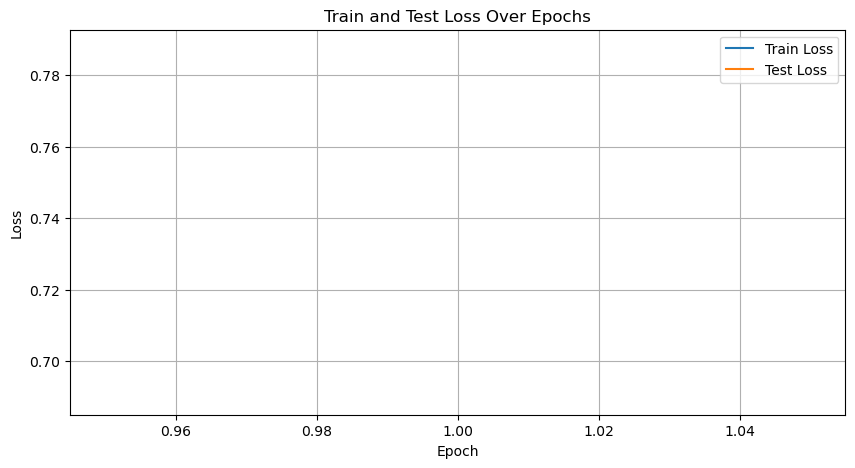

Epoch: 1
---------
Train Loss of [Batch 0/385]: 0.5882
Train Loss of [Batch 100/385]: 0.7488
Train Loss of [Batch 200/385]: 0.6006
Train Loss of [Batch 300/385]: 0.7471

Train loss: 0.67159 | Train accuracy: 75.93%
Train Class-wise Loss (class 0-9): tensor([0.9078, 0.3750], device='cuda:0')

Test loss: 0.62091 | Test accuracy: 73.45%
Test Class-wise Loss (class 0-9): tensor([1.1370, 0.2745], device='cuda:0')



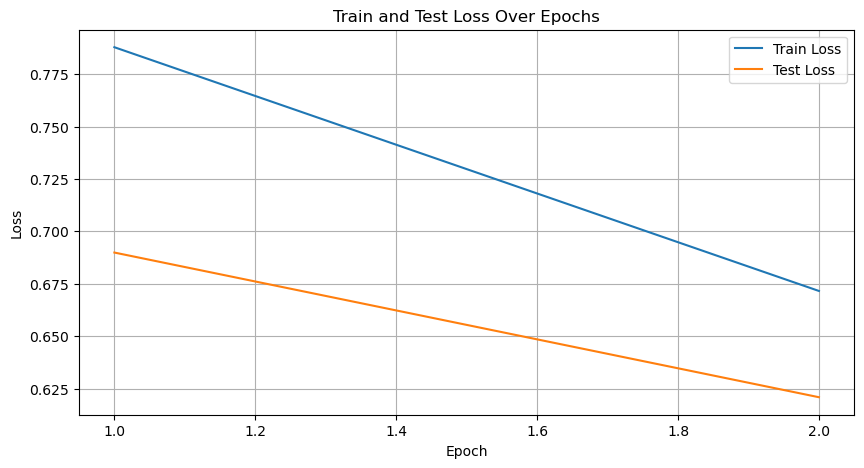

Epoch: 2
---------
Train Loss of [Batch 0/385]: 0.6060
Train Loss of [Batch 100/385]: 0.5505
Train Loss of [Batch 200/385]: 0.6984
Train Loss of [Batch 300/385]: 0.4933

Train loss: 0.60390 | Train accuracy: 79.55%
Train Class-wise Loss (class 0-9): tensor([0.8385, 0.3116], device='cuda:0')

Test loss: 0.56718 | Test accuracy: 77.54%
Test Class-wise Loss (class 0-9): tensor([1.0645, 0.2666], device='cuda:0')



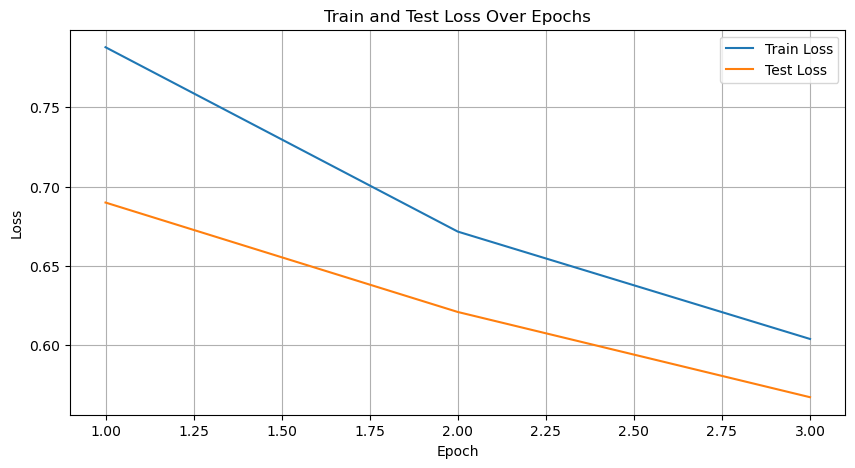

Epoch: 3
---------
Train Loss of [Batch 0/385]: 0.7625
Train Loss of [Batch 100/385]: 0.6557
Train Loss of [Batch 200/385]: 0.7122
Train Loss of [Batch 300/385]: 0.4882

Train loss: 0.56376 | Train accuracy: 82.16%
Train Class-wise Loss (class 0-9): tensor([0.7838, 0.2871], device='cuda:0')

Test loss: 0.54170 | Test accuracy: 78.42%
Test Class-wise Loss (class 0-9): tensor([1.0576, 0.2448], device='cuda:0')



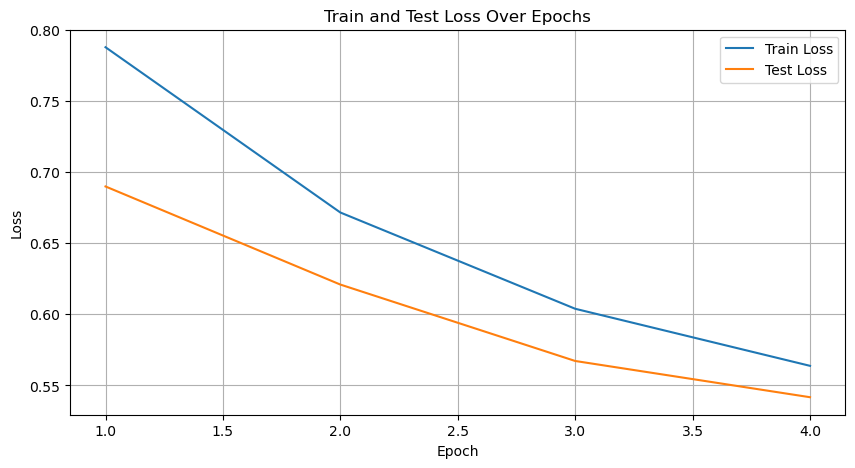

Epoch: 4
---------
Train Loss of [Batch 0/385]: 0.5764
Train Loss of [Batch 100/385]: 0.6627
Train Loss of [Batch 200/385]: 0.5042
Train Loss of [Batch 300/385]: 0.5880

Train loss: 0.52753 | Train accuracy: 83.82%
Train Class-wise Loss (class 0-9): tensor([0.7411, 0.2559], device='cuda:0')

Test loss: 0.51143 | Test accuracy: 80.08%
Test Class-wise Loss (class 0-9): tensor([0.9895, 0.2455], device='cuda:0')



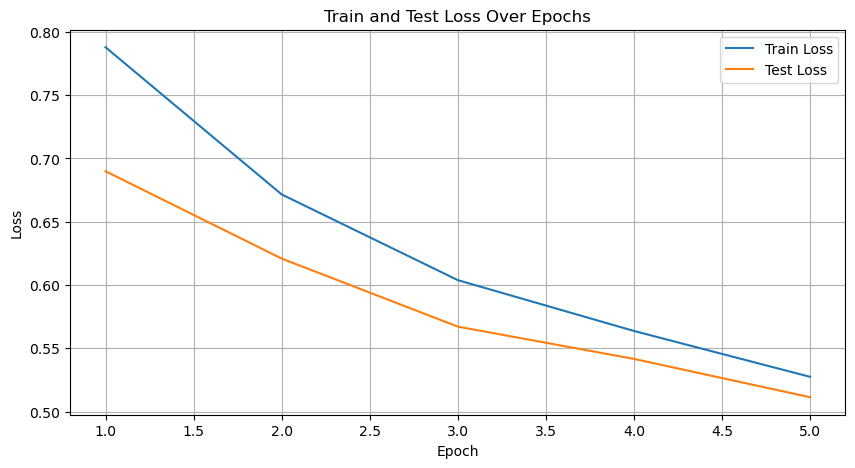

Epoch: 5
---------
Train Loss of [Batch 0/385]: 0.4807
Train Loss of [Batch 100/385]: 0.4377
Train Loss of [Batch 200/385]: 0.3621
Train Loss of [Batch 300/385]: 0.5116

Train loss: 0.50222 | Train accuracy: 84.68%
Train Class-wise Loss (class 0-9): tensor([0.7125, 0.2397], device='cuda:0')

Test loss: 0.50012 | Test accuracy: 80.50%
Test Class-wise Loss (class 0-9): tensor([1.0072, 0.2200], device='cuda:0')



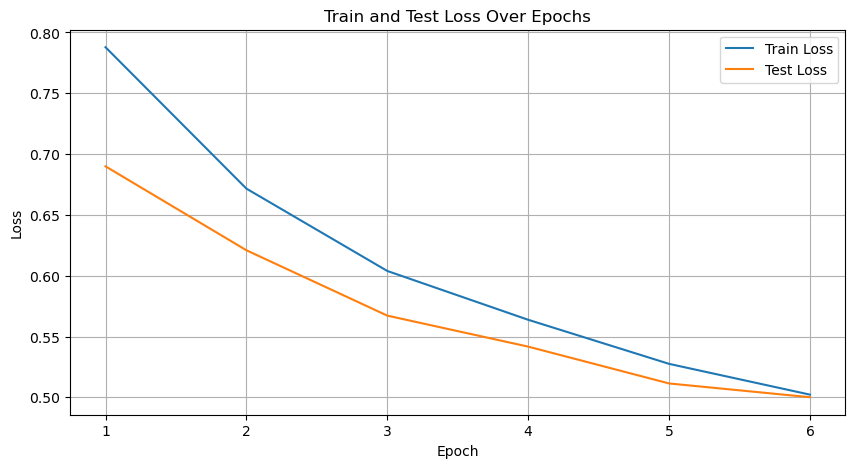

Epoch: 6
---------
Train Loss of [Batch 0/385]: 0.6079
Train Loss of [Batch 100/385]: 0.4049
Train Loss of [Batch 200/385]: 0.4011
Train Loss of [Batch 300/385]: 0.3812

Train loss: 0.48123 | Train accuracy: 85.68%
Train Class-wise Loss (class 0-9): tensor([0.6797, 0.2308], device='cuda:0')

Test loss: 0.46271 | Test accuracy: 82.13%
Test Class-wise Loss (class 0-9): tensor([0.8835, 0.2318], device='cuda:0')



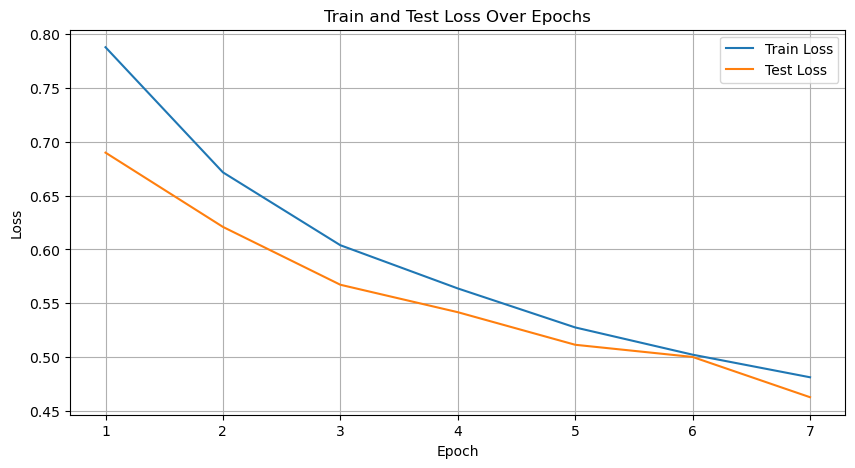

Epoch: 7
---------
Train Loss of [Batch 0/385]: 0.5396
Train Loss of [Batch 100/385]: 0.6679
Train Loss of [Batch 200/385]: 0.4690
Train Loss of [Batch 300/385]: 0.5261

Train loss: 0.45688 | Train accuracy: 86.61%
Train Class-wise Loss (class 0-9): tensor([0.6501, 0.2152], device='cuda:0')

Test loss: 0.43908 | Test accuracy: 83.80%
Test Class-wise Loss (class 0-9): tensor([0.8116, 0.2413], device='cuda:0')



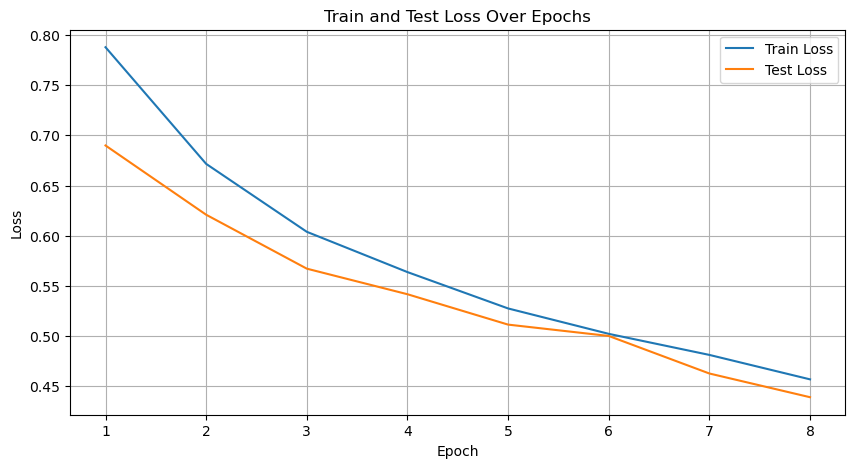

Epoch: 8
---------
Train Loss of [Batch 0/385]: 0.4166
Train Loss of [Batch 100/385]: 0.3448
Train Loss of [Batch 200/385]: 0.5724
Train Loss of [Batch 300/385]: 0.2973

Train loss: 0.43788 | Train accuracy: 87.32%
Train Class-wise Loss (class 0-9): tensor([0.6220, 0.2078], device='cuda:0')

Test loss: 0.43003 | Test accuracy: 83.39%
Test Class-wise Loss (class 0-9): tensor([0.8376, 0.2109], device='cuda:0')



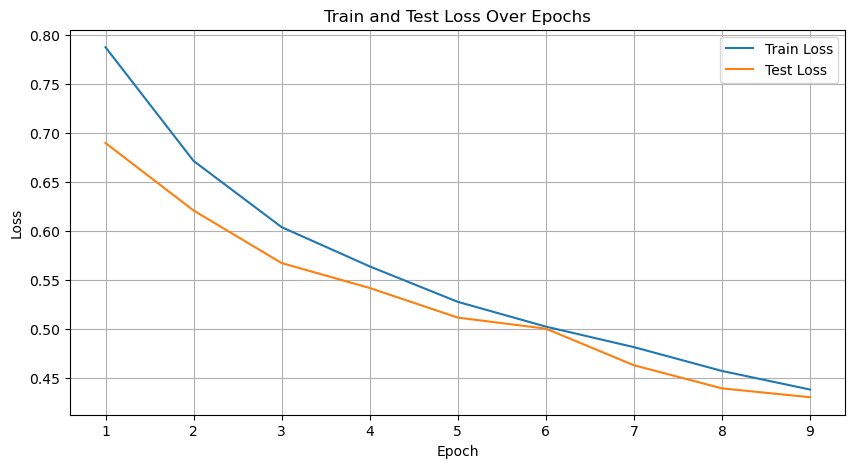

Epoch: 9
---------
Train Loss of [Batch 0/385]: 0.4046
Train Loss of [Batch 100/385]: 0.3911
Train Loss of [Batch 200/385]: 0.4244
Train Loss of [Batch 300/385]: 0.4978

Train loss: 0.41753 | Train accuracy: 88.16%
Train Class-wise Loss (class 0-9): tensor([0.5890, 0.1996], device='cuda:0')

Test loss: 0.41881 | Test accuracy: 83.74%
Test Class-wise Loss (class 0-9): tensor([0.8315, 0.2001], device='cuda:0')



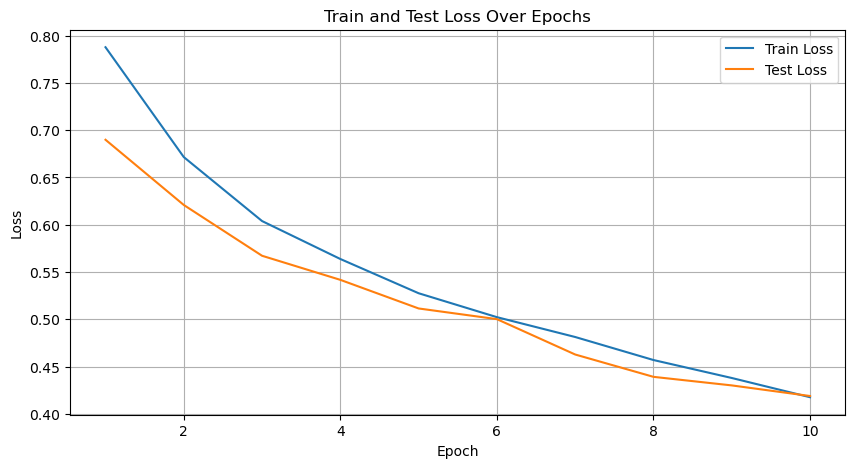

Epoch: 10
---------
Train Loss of [Batch 0/385]: 0.4661
Train Loss of [Batch 100/385]: 0.4297
Train Loss of [Batch 200/385]: 0.4865
Train Loss of [Batch 300/385]: 0.4507

Train loss: 0.39459 | Train accuracy: 88.74%
Train Class-wise Loss (class 0-9): tensor([0.5598, 0.1882], device='cuda:0')

Test loss: 0.40124 | Test accuracy: 84.54%
Test Class-wise Loss (class 0-9): tensor([0.7812, 0.2046], device='cuda:0')



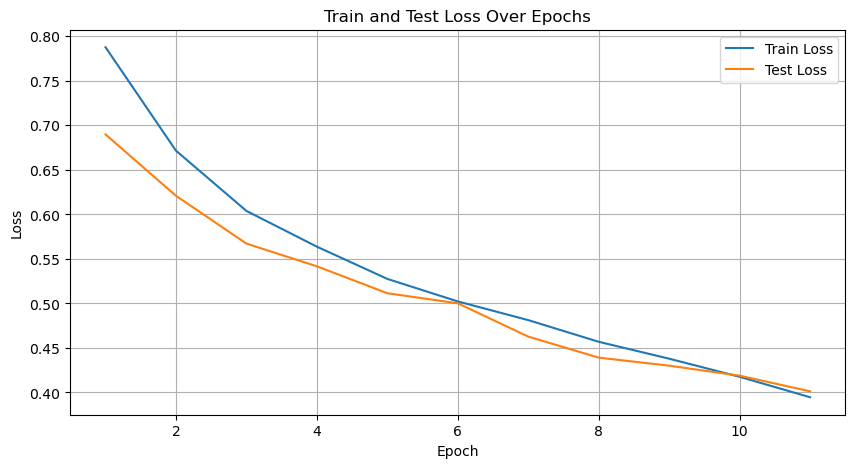

Epoch: 11
---------
Train Loss of [Batch 0/385]: 0.3579
Train Loss of [Batch 100/385]: 0.2933
Train Loss of [Batch 200/385]: 0.3739
Train Loss of [Batch 300/385]: 0.4099

Train loss: 0.38179 | Train accuracy: 89.27%
Train Class-wise Loss (class 0-9): tensor([0.5343, 0.1831], device='cuda:0')

Test loss: 0.36313 | Test accuracy: 86.99%
Test Class-wise Loss (class 0-9): tensor([0.6107, 0.2541], device='cuda:0')



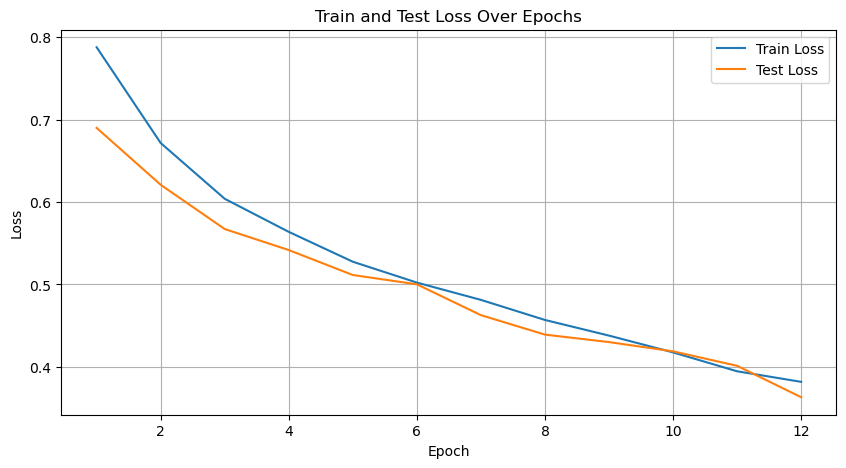

Epoch: 12
---------
Train Loss of [Batch 0/385]: 0.3570
Train Loss of [Batch 100/385]: 0.4768
Train Loss of [Batch 200/385]: 0.5276
Train Loss of [Batch 300/385]: 0.2981

Train loss: 0.36036 | Train accuracy: 89.45%
Train Class-wise Loss (class 0-9): tensor([0.5140, 0.1698], device='cuda:0')

Test loss: 0.36581 | Test accuracy: 84.50%
Test Class-wise Loss (class 0-9): tensor([0.6690, 0.2149], device='cuda:0')



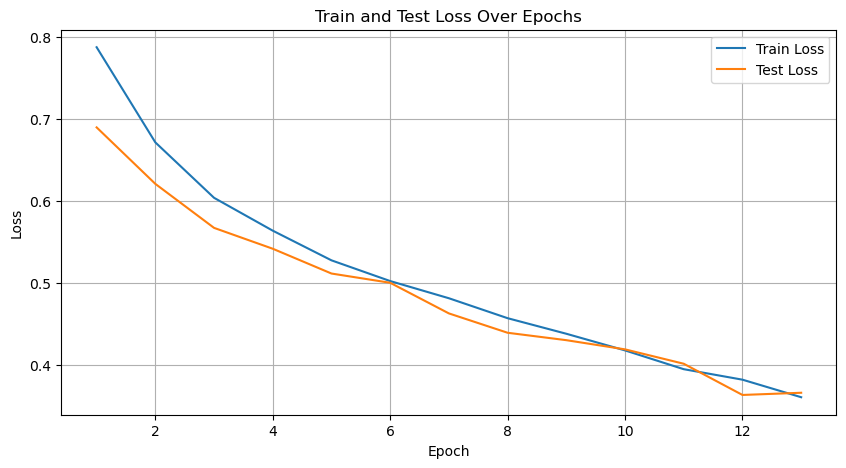

Epoch: 13
---------
Train Loss of [Batch 0/385]: 0.3457
Train Loss of [Batch 100/385]: 0.4693
Train Loss of [Batch 200/385]: 0.4655
Train Loss of [Batch 300/385]: 0.3074

Train loss: 0.34841 | Train accuracy: 89.79%
Train Class-wise Loss (class 0-9): tensor([0.4942, 0.1662], device='cuda:0')

Test loss: 0.34928 | Test accuracy: 85.89%
Test Class-wise Loss (class 0-9): tensor([0.6119, 0.2300], device='cuda:0')



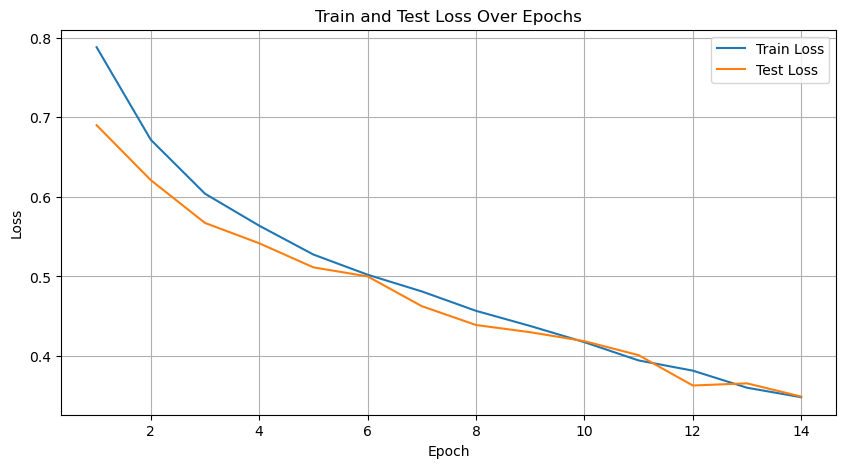

Epoch: 14
---------
Train Loss of [Batch 0/385]: 0.3527
Train Loss of [Batch 100/385]: 0.4419
Train Loss of [Batch 200/385]: 0.3476
Train Loss of [Batch 300/385]: 0.3692

Train loss: 0.33845 | Train accuracy: 90.10%
Train Class-wise Loss (class 0-9): tensor([0.4758, 0.1583], device='cuda:0')

Test loss: 0.34265 | Test accuracy: 86.02%
Test Class-wise Loss (class 0-9): tensor([0.5933, 0.2311], device='cuda:0')



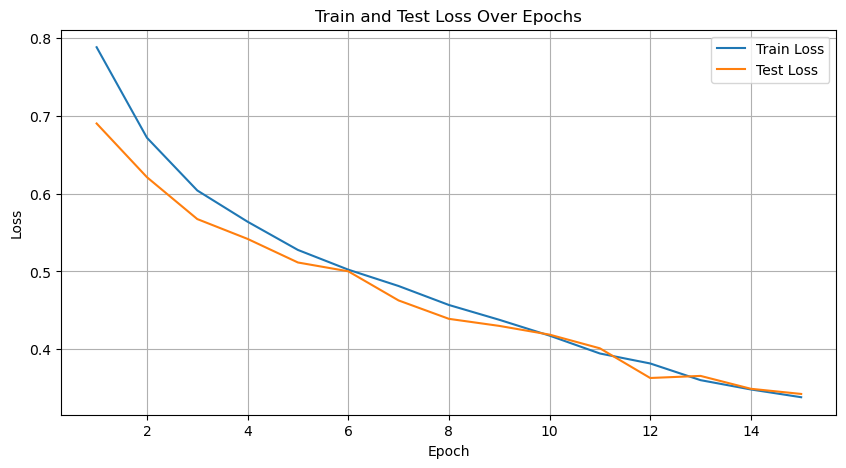

Epoch: 15
---------
Train Loss of [Batch 0/385]: 0.3401
Train Loss of [Batch 100/385]: 0.3913
Train Loss of [Batch 200/385]: 0.3215
Train Loss of [Batch 300/385]: 0.2827

Train loss: 0.32181 | Train accuracy: 90.46%
Train Class-wise Loss (class 0-9): tensor([0.4577, 0.1485], device='cuda:0')

Test loss: 0.33204 | Test accuracy: 86.81%
Test Class-wise Loss (class 0-9): tensor([0.5591, 0.2383], device='cuda:0')



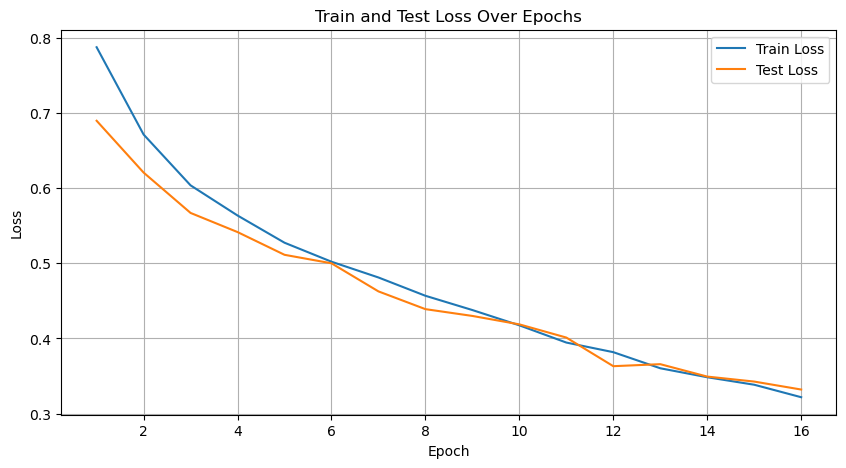

Epoch: 16
---------
Train Loss of [Batch 0/385]: 0.3415
Train Loss of [Batch 100/385]: 0.3805
Train Loss of [Batch 200/385]: 0.4704
Train Loss of [Batch 300/385]: 0.3443

Train loss: 0.31066 | Train accuracy: 90.76%
Train Class-wise Loss (class 0-9): tensor([0.4436, 0.1413], device='cuda:0')

Test loss: 0.32865 | Test accuracy: 86.08%
Test Class-wise Loss (class 0-9): tensor([0.5740, 0.2264], device='cuda:0')



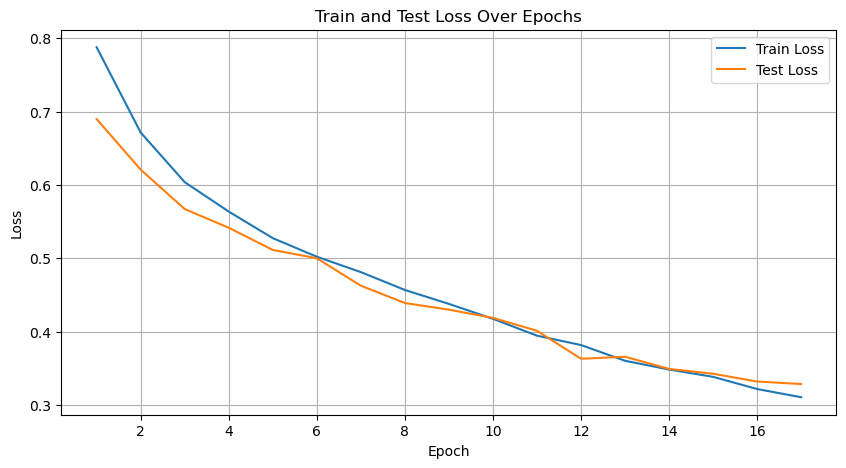

Epoch: 17
---------
Train Loss of [Batch 0/385]: 0.3397
Train Loss of [Batch 100/385]: 0.3051
Train Loss of [Batch 200/385]: 0.3183
Train Loss of [Batch 300/385]: 0.2965

Train loss: 0.30315 | Train accuracy: 91.18%
Train Class-wise Loss (class 0-9): tensor([0.4268, 0.1399], device='cuda:0')

Test loss: 0.32357 | Test accuracy: 86.40%
Test Class-wise Loss (class 0-9): tensor([0.5593, 0.2273], device='cuda:0')



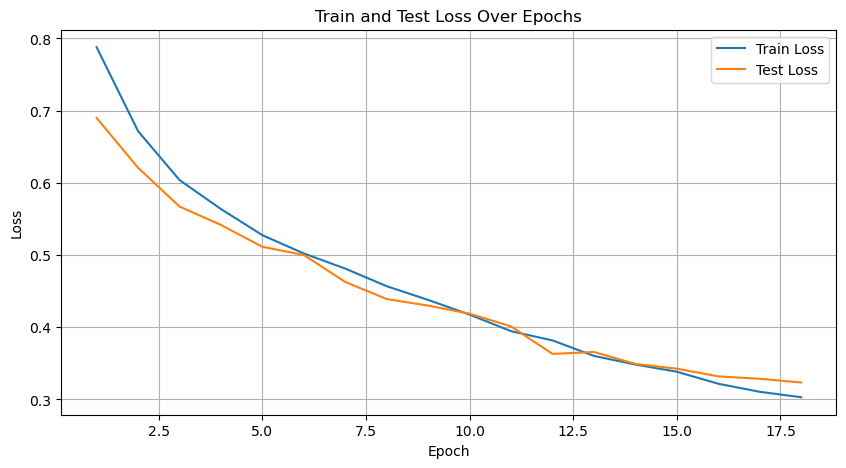

Epoch: 18
---------
Train Loss of [Batch 0/385]: 0.2364
Train Loss of [Batch 100/385]: 0.2782
Train Loss of [Batch 200/385]: 0.2333
Train Loss of [Batch 300/385]: 0.1992

Train loss: 0.29020 | Train accuracy: 91.54%
Train Class-wise Loss (class 0-9): tensor([0.4131, 0.1307], device='cuda:0')

Test loss: 0.31196 | Test accuracy: 89.12%
Test Class-wise Loss (class 0-9): tensor([0.4950, 0.2635], device='cuda:0')



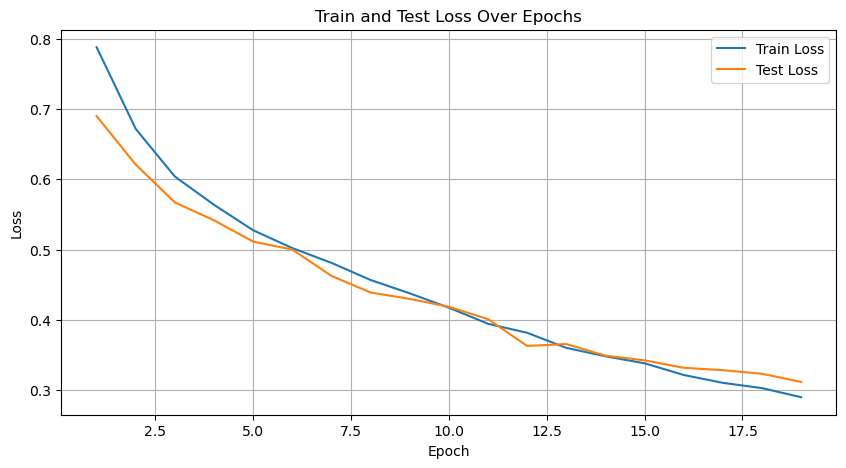

Epoch: 19
---------
Train Loss of [Batch 0/385]: 0.3683
Train Loss of [Batch 100/385]: 0.2636
Train Loss of [Batch 200/385]: 0.2581
Train Loss of [Batch 300/385]: 0.2944

Train loss: 0.28263 | Train accuracy: 91.88%
Train Class-wise Loss (class 0-9): tensor([0.3997, 0.1280], device='cuda:0')

Test loss: 0.30907 | Test accuracy: 88.66%
Test Class-wise Loss (class 0-9): tensor([0.4732, 0.2646], device='cuda:0')



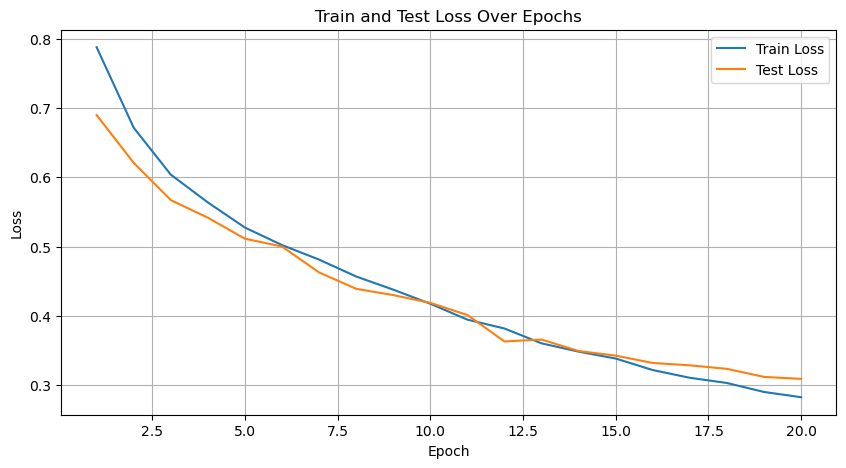

Epoch: 20
---------
Train Loss of [Batch 0/385]: 0.2292
Train Loss of [Batch 100/385]: 0.2363
Train Loss of [Batch 200/385]: 0.2897
Train Loss of [Batch 300/385]: 0.2551

Train loss: 0.26567 | Train accuracy: 92.26%
Train Class-wise Loss (class 0-9): tensor([0.3864, 0.1175], device='cuda:0')

Test loss: 0.30435 | Test accuracy: 88.21%
Test Class-wise Loss (class 0-9): tensor([0.4956, 0.2444], device='cuda:0')



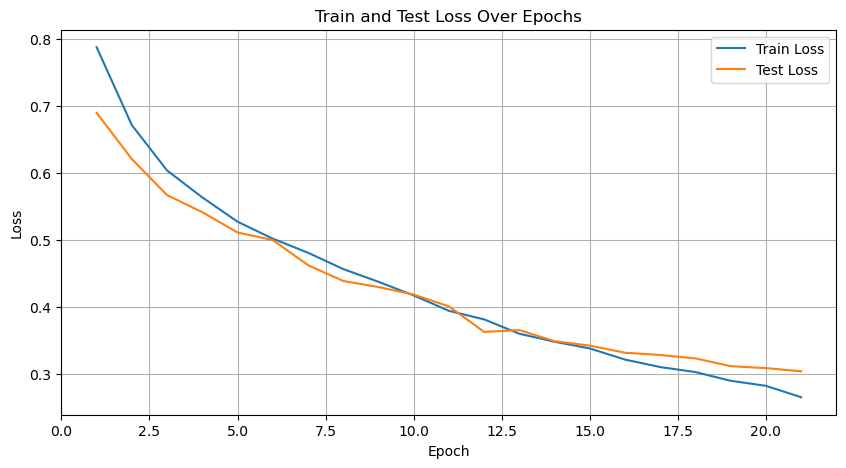

Epoch: 21
---------
Train Loss of [Batch 0/385]: 0.1886
Train Loss of [Batch 100/385]: 0.2369
Train Loss of [Batch 200/385]: 0.2444
Train Loss of [Batch 300/385]: 0.2850

Train loss: 0.26005 | Train accuracy: 92.64%
Train Class-wise Loss (class 0-9): tensor([0.3742, 0.1122], device='cuda:0')

Test loss: 0.30177 | Test accuracy: 90.20%
Test Class-wise Loss (class 0-9): tensor([0.4304, 0.2916], device='cuda:0')



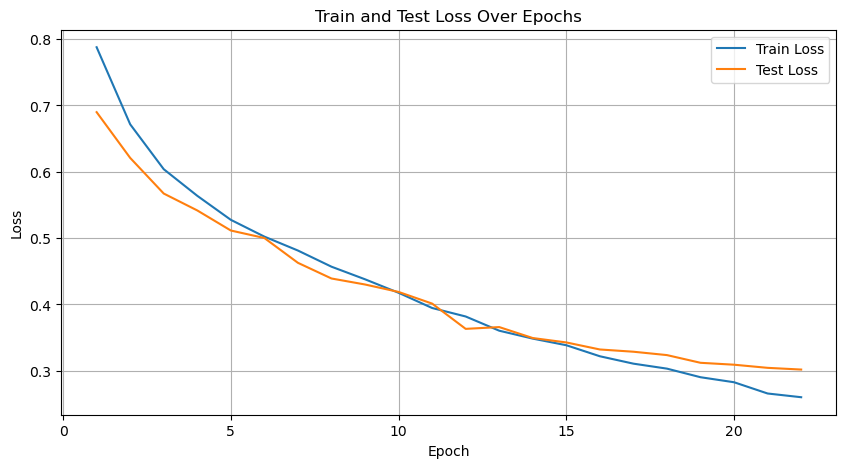

Epoch: 22
---------
Train Loss of [Batch 0/385]: 0.2462
Train Loss of [Batch 100/385]: 0.2809
Train Loss of [Batch 200/385]: 0.1994
Train Loss of [Batch 300/385]: 0.3351

Train loss: 0.25225 | Train accuracy: 92.98%
Train Class-wise Loss (class 0-9): tensor([0.3614, 0.1102], device='cuda:0')

Test loss: 0.29823 | Test accuracy: 90.10%
Test Class-wise Loss (class 0-9): tensor([0.4400, 0.2836], device='cuda:0')



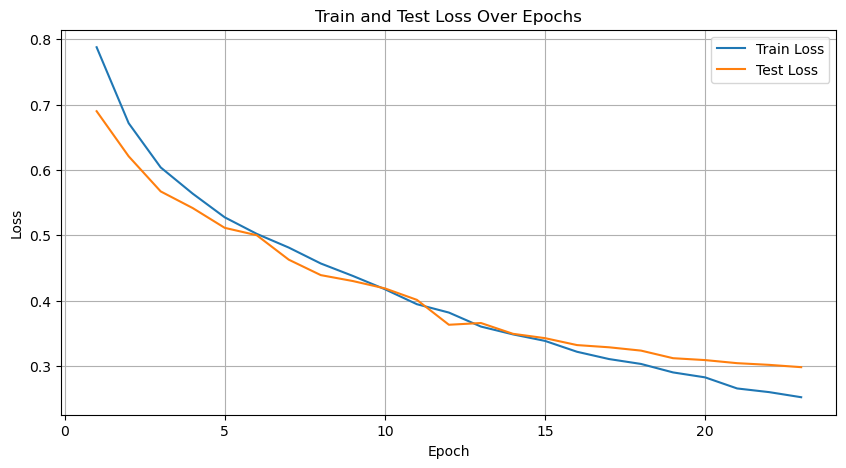

Epoch: 23
---------
Train Loss of [Batch 0/385]: 0.3414
Train Loss of [Batch 100/385]: 0.2407
Train Loss of [Batch 200/385]: 0.2483
Train Loss of [Batch 300/385]: 0.2177

Train loss: 0.24365 | Train accuracy: 93.32%
Train Class-wise Loss (class 0-9): tensor([0.3499, 0.1066], device='cuda:0')

Test loss: 0.29344 | Test accuracy: 89.45%
Test Class-wise Loss (class 0-9): tensor([0.4464, 0.2671], device='cuda:0')



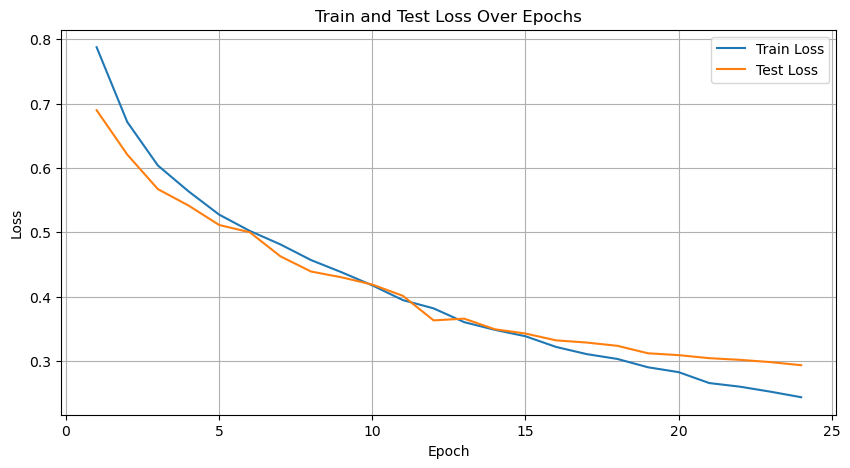

Epoch: 24
---------
Train Loss of [Batch 0/385]: 0.2751
Train Loss of [Batch 100/385]: 0.2239
Train Loss of [Batch 200/385]: 0.3568
Train Loss of [Batch 300/385]: 0.1676

Train loss: 0.23322 | Train accuracy: 93.64%
Train Class-wise Loss (class 0-9): tensor([0.3374, 0.1005], device='cuda:0')

Test loss: 0.29371 | Test accuracy: 90.16%
Test Class-wise Loss (class 0-9): tensor([0.4581, 0.2734], device='cuda:0')



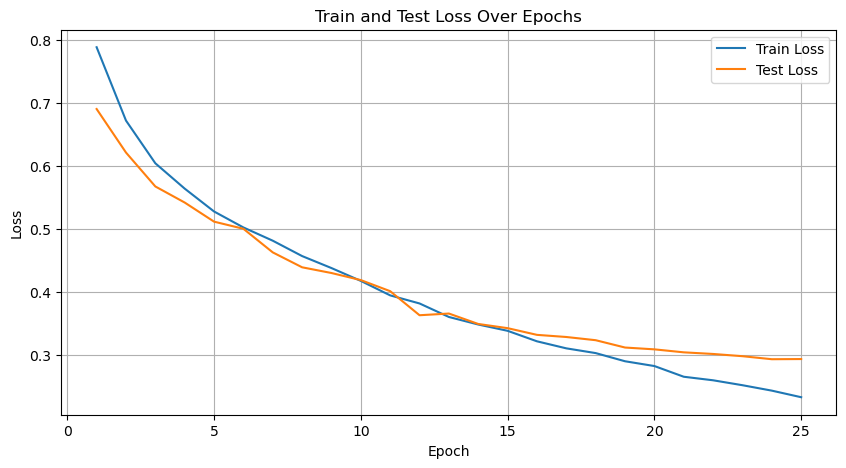

Epoch: 25
---------
Train Loss of [Batch 0/385]: 0.3248
Train Loss of [Batch 100/385]: 0.2925
Train Loss of [Batch 200/385]: 0.2132
Train Loss of [Batch 300/385]: 0.2070

Train loss: 0.22711 | Train accuracy: 93.95%
Train Class-wise Loss (class 0-9): tensor([0.3276, 0.0981], device='cuda:0')

Test loss: 0.29076 | Test accuracy: 89.99%
Test Class-wise Loss (class 0-9): tensor([0.4354, 0.2840], device='cuda:0')



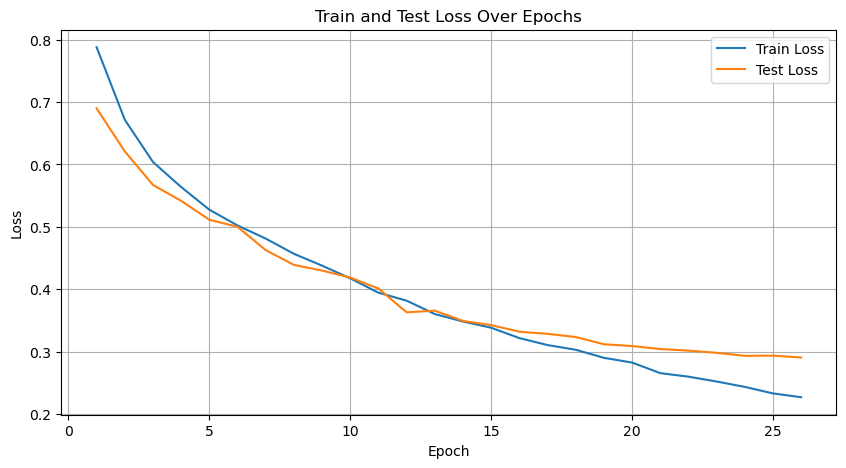

Epoch: 26
---------
Train Loss of [Batch 0/385]: 0.2812
Train Loss of [Batch 100/385]: 0.1799
Train Loss of [Batch 200/385]: 0.2182
Train Loss of [Batch 300/385]: 0.2733

Train loss: 0.22063 | Train accuracy: 94.24%
Train Class-wise Loss (class 0-9): tensor([0.3166, 0.0947], device='cuda:0')

Test loss: 0.28900 | Test accuracy: 91.37%
Test Class-wise Loss (class 0-9): tensor([0.3926, 0.3095], device='cuda:0')



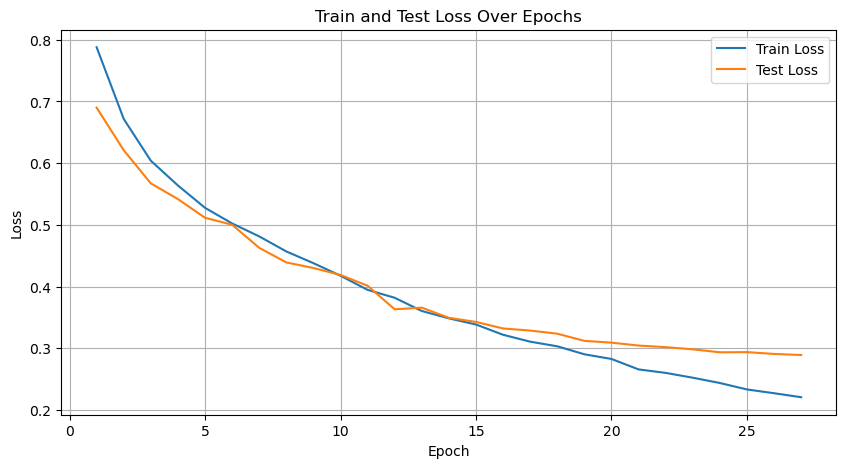

Epoch: 27
---------
Train Loss of [Batch 0/385]: 0.3108
Train Loss of [Batch 100/385]: 0.3308
Train Loss of [Batch 200/385]: 0.1901
Train Loss of [Batch 300/385]: 0.2606

Train loss: 0.21290 | Train accuracy: 94.50%
Train Class-wise Loss (class 0-9): tensor([0.3065, 0.0910], device='cuda:0')

Test loss: 0.28897 | Test accuracy: 90.84%
Test Class-wise Loss (class 0-9): tensor([0.4172, 0.3010], device='cuda:0')



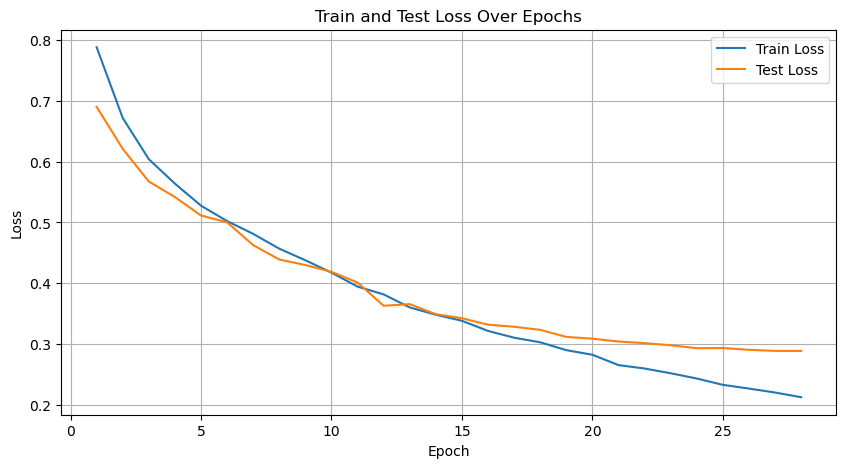

Epoch: 28
---------
Train Loss of [Batch 0/385]: 0.2063
Train Loss of [Batch 100/385]: 0.2211
Train Loss of [Batch 200/385]: 0.2486
Train Loss of [Batch 300/385]: 0.1621

Train loss: 0.20664 | Train accuracy: 94.76%
Train Class-wise Loss (class 0-9): tensor([0.2968, 0.0872], device='cuda:0')

Test loss: 0.28880 | Test accuracy: 92.40%
Test Class-wise Loss (class 0-9): tensor([0.3691, 0.3453], device='cuda:0')



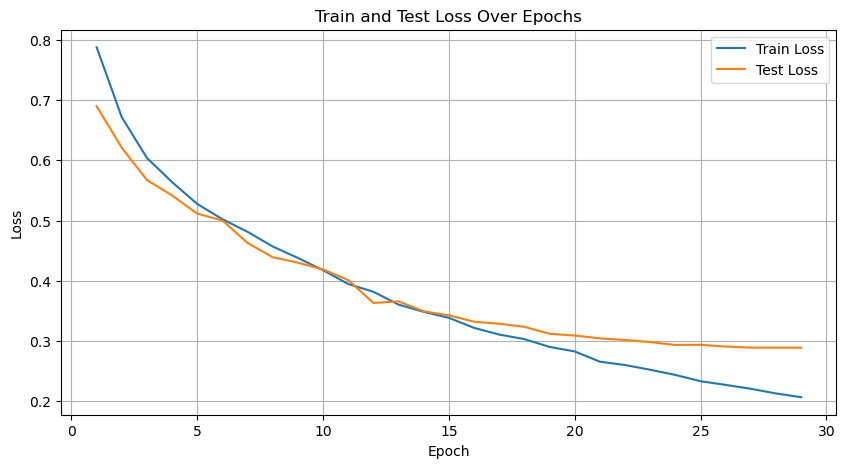

Epoch: 29
---------
Train Loss of [Batch 0/385]: 0.2259
Train Loss of [Batch 100/385]: 0.1617
Train Loss of [Batch 200/385]: 0.1737
Train Loss of [Batch 300/385]: 0.1577

Train loss: 0.20019 | Train accuracy: 95.04%
Train Class-wise Loss (class 0-9): tensor([0.2860, 0.0862], device='cuda:0')

Test loss: 0.29110 | Test accuracy: 92.45%
Test Class-wise Loss (class 0-9): tensor([0.3605, 0.3527], device='cuda:0')



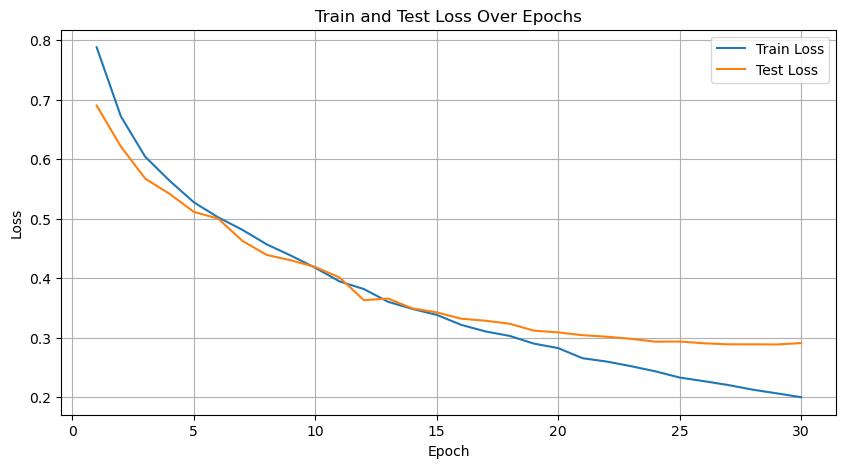

Train time on cuda: 5419.972 seconds


In [106]:
from tqdm.auto import tqdm

# Fix random seed for reproducibility
torch.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.cuda.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Learning rate:", configs_sc.HYPERPARAMETERS["learning_rate"])
print("Number of epochs:", configs_sc.HYPERPARAMETERS["epochs"])

# measure time with timing function
from timeit import default_timer as timer
start = timer()

# empty lists for storing of evaluation metrics
train_loss_progress = []
test_loss_progress = []
train_class_wise_losses = []
test_class_wise_losses = []

# epoch loop
for epoch in tqdm(range(configs_sc.HYPERPARAMETERS["epochs"])):
    print(f"Epoch: {epoch}\n---------") # print current epoch

    train_loss_epoch, train_class_wise_loss = train_utils.train_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    train_loss_progress.append({"epoch": epoch + 1, "train loss": train_loss_epoch})
    train_class_wise_losses.append(train_class_wise_loss.cpu().numpy())  # change to numpy for easier plotting

    test_loss_epoch, test_class_wise_loss = train_utils.test_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=test_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_loss_progress.append({"epoch": epoch + 1, "test loss": test_loss_epoch})
    test_class_wise_losses.append(test_class_wise_loss.cpu().numpy())


    # Clear output and update plot
    epochs = [entry["epoch"] for entry in train_loss_progress]
    train_losses = [entry["train loss"] for entry in train_loss_progress]
    test_losses = [entry["test loss"].cpu().item() for entry in test_loss_progress]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()



end = timer()
train_utils.print_train_time(start, end, device)

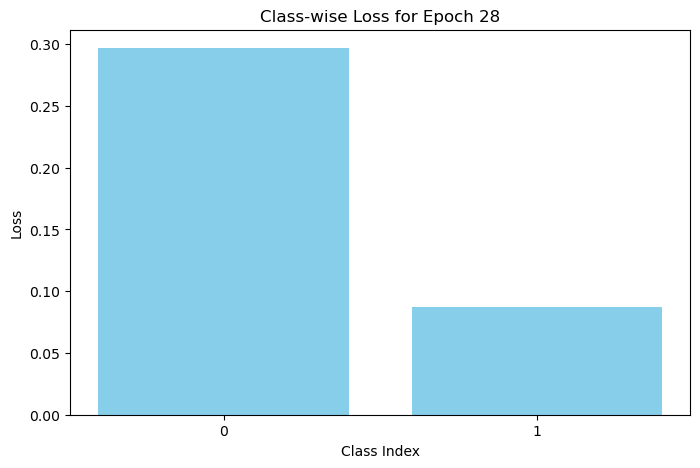

In [107]:
# Plot train class-wise loss of a specific epoch
# ADJUSTABLE!
try_epoch = 28
visualization_utils.plot_classwise_loss(try_epoch, train_class_wise_losses, configs_sc.HYPERPARAMETERS["num_classes"])

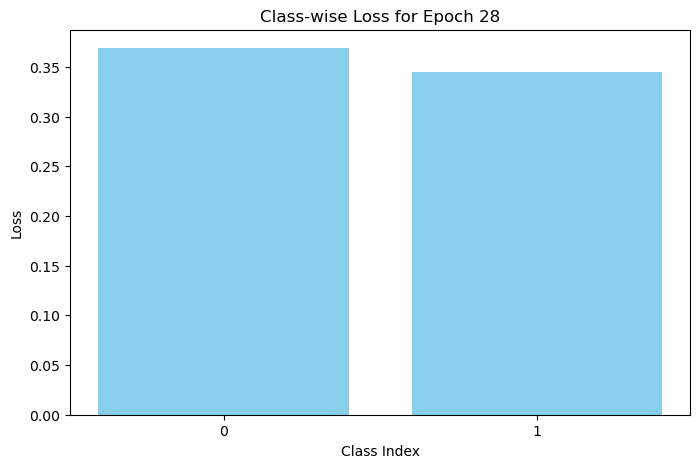

In [108]:
# Plot test class-wise loss of a specific epoch
visualization_utils.plot_classwise_loss(try_epoch, test_class_wise_losses, configs_sc.HYPERPARAMETERS["num_classes"])

## 5. Save and load trained model

1. Create individual name of the trained

In [109]:
# Create INDIVIDUAL model name and add to corresponding path

# counter for model version
counter = 1

# function for generating initial model name
def generate_model_name(base_name, learning_rate, epochs, counter):
    return f"{base_name}_{learning_rate}_{epochs}_{counter}.pth"

base_name = "unet_model_2classes"

# generate initial name and path
MODEL_NAME = generate_model_name(base_name, configs_sc.HYPERPARAMETERS["learning_rate"], configs_sc.HYPERPARAMETERS["epochs"], counter)
save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

# check if there is already a model saved with the same name -> if so: increase the counter
while os.path.exists(save_model_path):
    print(f"Warning: File with name {MODEL_NAME} already exists. Increase the counter...")
    counter += 1
    MODEL_NAME = generate_model_name(base_name, configs_sc.HYPERPARAMETERS["learning_rate"], configs_sc.HYPERPARAMETERS["epochs"], counter)
    save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

2. Save the models state dict

In [110]:
# Save the models state dict
print(f"Saving model to: {save_model_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=save_model_path)

Saving model to: /home/sc.uni-leipzig.de/rf37uqip/MoSE/saved_models/unet_model_2classes_1e-06_30_1.pth


**3. Load the model**

In [111]:
# Load the model

#######
MODEL_NAME = "unet_model_2classes_1e-06_30_1.pth" # ---------> ADJUSTABLE!
#######
save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

# Create a new instance of the model (same class as our saved state_dict())
loaded_model = model_utils.model_0.to(device)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=save_model_path, weights_only=True))

# Send model to GPU
loaded_model = loaded_model.to(device)

## 6. Evaluate trained model

Make predictions for the entire test data set with the trained model and display the results in a confusion matrix.

### 6.1 Confusion Matrix, Accuracies and F1-Scores
Confusion Matrix for entire test data set!

Test accuracy: 92.45%

Test class-wise accuracies: [0.9299924975856427, 0.7190535697719833]



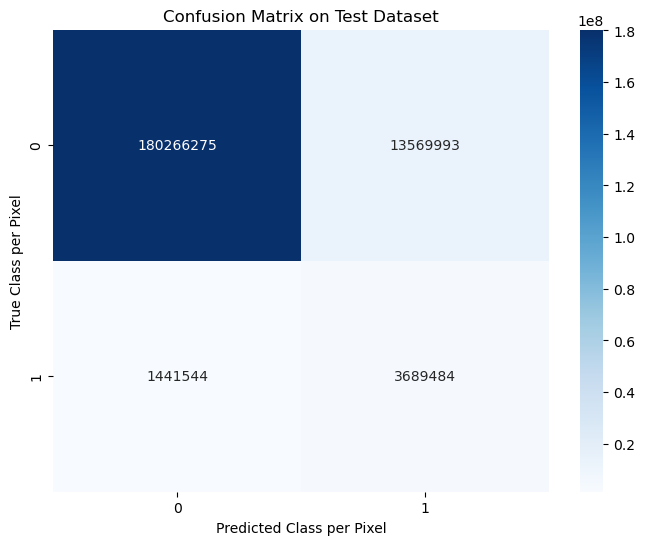

Class-wise F1-Scores:
   Class  F1-Score
0      0    0.9600
1      1    0.3296

Macro F1-Score: 0.6448


In [112]:
# predictions for entire test data set
evaluation_utils.evaluate_model_with_testdata(loaded_model, test_loader, accuracy_fn, configs_sc.HYPERPARAMETERS["num_classes"], device, F1_analysis = True)

Confusion Matrix, Accuracies and F1-Scores for a part of the test data set!

Test accuracy: 90.37%

Test class-wise accuracies: [0.9095256068067229, 0.6927940100208299]



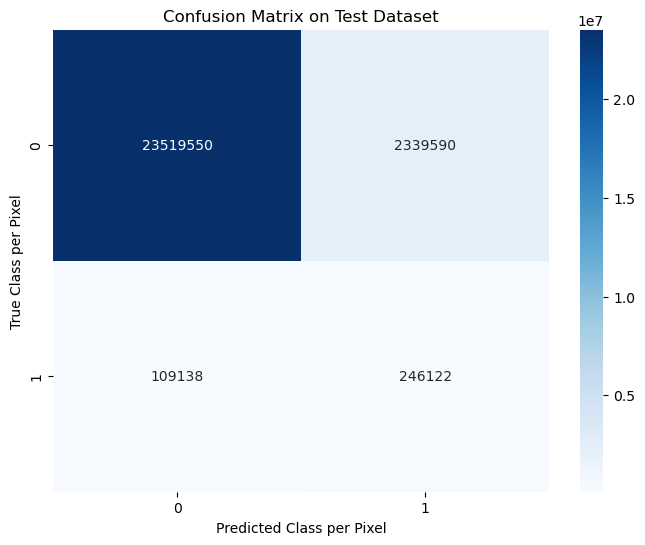

Class-wise F1-Scores:
   Class  F1-Score
0      0    0.9505
1      1    0.1674

Macro F1-Score: 0.5589


In [113]:
# predictions for a part of the test data set
from torch.utils.data import Subset

# use only __ patch(es) of the test data set
subset_indices = range(100)  # indices of sample test data set
subset_test_data = Subset(test_loader.dataset, subset_indices)


# create subset of test_loader
subset_test_loader = DataLoader(subset_test_data, batch_size=test_loader.batch_size, shuffle=False)

evaluation_utils.evaluate_model_with_testdata(
    loaded_model, subset_test_loader, accuracy_fn, 
    configs_sc.HYPERPARAMETERS["num_classes"], device, 
    F1_analysis = True)

### 6.2 Visual Evaluation

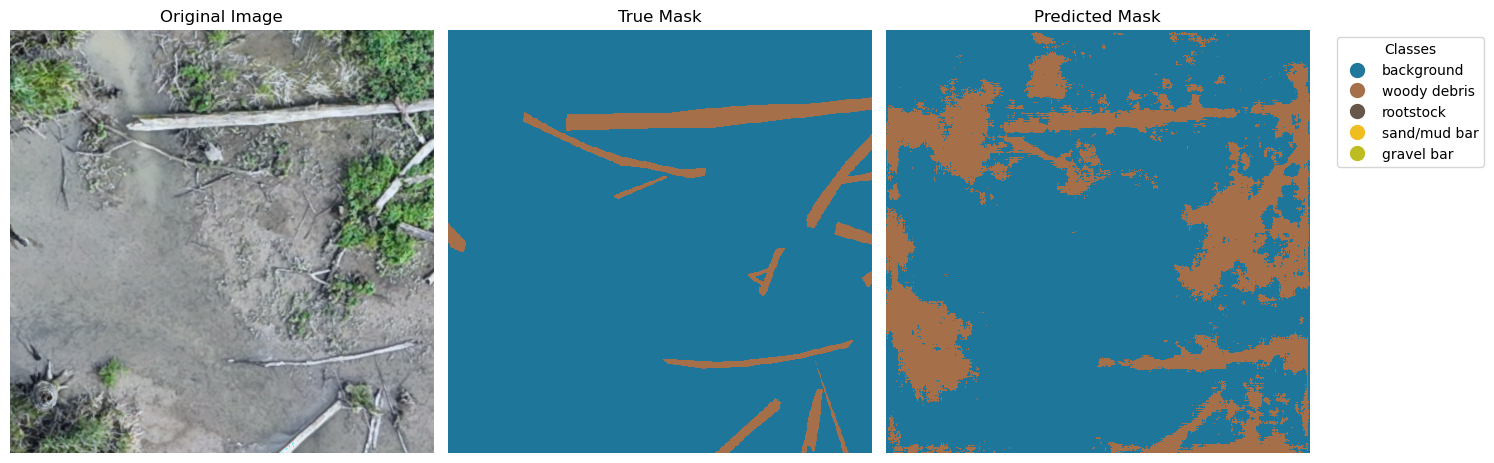

In [121]:
##################### Choose single patch by section and id
SECTION = "A04" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 207 # -------------------->> ADJUSTABLE
#####################
# 1432

# Name of chosen patch
test_patch_name = f"{SECTION}_patch_{TEST_PATCH_ID}.npy"

visualization_utils.visualize_prediction(test_patch_name, test_loader, loaded_model, device, reversed_codes, configs_sc.HYPERPARAMETERS["custom_colors"])

## Citing

In [ ]:
# @misc{Iakubovskii:2019,
#   Author = {Pavel Iakubovskii},
#   Title = {Segmentation Models Pytorch},
#   Year = {2019},
#   Publisher = {GitHub},
#   Journal = {GitHub repository},
#   Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
# }